In [2]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures 


In [3]:
df_values = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
df_labels = pd.read_csv('Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')


drop_columns = ['id', 'funder', 'num_private', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region_code', 'lga',
                'ward','recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'quality_group', 
                'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

continuous_columns = ['amount_tsh', 'date_recorded', 'gps_height', 'population', 'construction_year']

categorical_columns = ['installer', 'basin', 'region', 'district_code', 'public_meeting',
                      'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', 'management', 
                      'management_group', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type']

df_original = pd.merge(df_values, df_labels, on = 'id', how = 'inner')

df_original.drop(drop_columns, axis = 1, inplace = True)

df_original.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'basin',
       'region', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'water_quality', 'quantity', 'source',
       'waterpoint_type', 'status_group'],
      dtype='object')

### Clean data/one hot encoding
this portion will look at all the object data points and see whether or not they should be one hot encoded and/or binned.
1. filter out all the non-object data types and count the number of unique values to see if they would be uselful for classification. 
2. Delete columns that have significant overlap or are not good for one-hot-encoding
3. For date of recording, we plan on turning this into an interger by subtracting every date from the most recent date to get a value for how many dates have passed.

In [4]:
uvdict = {}

for column in df_original.select_dtypes(exclude=['int','float']):
    values_list = df_original[column].unique()
    uvdict[column] = len(values_list)

uvdict

{'date_recorded': 356,
 'installer': 2146,
 'basin': 9,
 'region': 21,
 'public_meeting': 3,
 'scheme_management': 13,
 'permit': 3,
 'extraction_type': 18,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment_type': 7,
 'water_quality': 8,
 'quantity': 5,
 'source': 10,
 'waterpoint_type': 7,
 'status_group': 3}

In [5]:
# returns the number of nonvalues in the dictionary
nan_dict = {}

for column in df_original.select_dtypes(exclude=['int','float']):
    nan_dict[column] = df_original[column].isna().sum()

nan_dict

{'date_recorded': 0,
 'installer': 3655,
 'basin': 0,
 'region': 0,
 'public_meeting': 3334,
 'scheme_management': 3877,
 'permit': 3056,
 'extraction_type': 0,
 'extraction_type_class': 0,
 'management': 0,
 'management_group': 0,
 'payment_type': 0,
 'water_quality': 0,
 'quantity': 0,
 'source': 0,
 'waterpoint_type': 0,
 'status_group': 0}

'recorded_by', 'funder', 'scheme_name' were the three columns to delete outright. Funder was removed because it was nearly identical to installer but contained fewer unique values. For scheme_name, nearly half the data was missing and it seem to relate to scheme management, and 'recorded_by' only has one value making it useless for predictions.

In [6]:
nan_dict = {}

for column in df_original.select_dtypes(exclude=['int','float']):
    nan_dict[column] = df_original[column].isna().sum()

nan_dict

{'date_recorded': 0,
 'installer': 3655,
 'basin': 0,
 'region': 0,
 'public_meeting': 3334,
 'scheme_management': 3877,
 'permit': 3056,
 'extraction_type': 0,
 'extraction_type_class': 0,
 'management': 0,
 'management_group': 0,
 'payment_type': 0,
 'water_quality': 0,
 'quantity': 0,
 'source': 0,
 'waterpoint_type': 0,
 'status_group': 0}

In [7]:
# replace NaN values with 'not_listed string'
df_original.loc[:, ['installer', 'scheme_management','public_meeting','permit']] = df_original.loc[:, ['installer', 'scheme_management','subvillage','public_meeting','permit']].fillna('Not known')


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [1]:
df_original.info()

NameError: name 'df_original' is not defined

In [8]:
# replace values with fewer than 200
threshold = 200
cols = ['installer']

for col in cols:
    valued_dict = dict(df_original[col].value_counts())
    safe_values = list(key for key, value in valued_dict.items() if value >= threshold)
#     replace_values = list(filter(lambda x: x not in safe_values, all_values))
    df_original.loc[:, col] = df_original.loc[:, col].map(lambda y: 'other' if y not in safe_values else y)

df_original.installer.value_counts()

other                         19710
DWE                           17402
Not known                      3672
Government                     1825
RWE                            1206
Commu                          1060
DANIDA                         1050
KKKT                            898
Hesawa                          840
0                               777
TCRS                            707
Central government              622
CES                             610
Community                       553
DANID                           552
District Council                551
HESAWA                          539
LGA                             408
World vision                    408
WEDECO                          397
TASAF                           396
District council                392
Gover                           383
AMREF                           329
TWESA                           316
WU                              301
Dmdd                            287
ACRA                        

In [9]:
basedate = datetime(2020, 1, 1)
a = list(range(1955,2016,5))
cut_bins = [-1]
cut_bins.extend(a)
cut_labels = ['not available', '56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-00','01-05','06-10','11-15']
df_original.loc[:, 'construction_year_bin'] = pd.cut(df_original['construction_year'], bins = cut_bins, labels = cut_labels)

df_original.construction_year_bin

0                96-00
1                06-10
2                06-10
3                86-90
4        not available
             ...      
59395            96-00
59396            96-00
59397    not available
59398    not available
59399            01-05
Name: construction_year_bin, Length: 59400, dtype: category
Categories (13, object): [not available < 56-60 < 61-65 < 66-70 ... 96-00 < 01-05 < 06-10 < 11-15]

In [10]:
df_original['days_since_recording'] = df_original.loc[:,'date_recorded'].map(lambda x: (basedate - datetime.strptime(x, "%Y-%m-%d")).days)



In [11]:
df_original.district_code = df_original.district_code.astype('str')

In [12]:
new_drop_list = ['date_recorded', 'construction_year']

df_cleaned = df_original.drop(new_drop_list, axis = 1)
df_cleaned

,amount_tsh,gps_height,installer,basin,region,district_code,population,public_meeting,scheme_management,permit,...,management,management_group,payment_type,water_quality,quantity,source,waterpoint_type,status_group,construction_year_bin,days_since_recording
0,6000.0,1390,other,Lake Nyasa,Iringa,5,109,True,VWC,False,...,vwc,user-group,annually,soft,enough,spring,communal standpipe,functional,96-00,3215
1,0.0,1399,other,Lake Victoria,Mara,2,280,Not known,Other,True,...,wug,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,06-10,2492
2,25.0,686,World vision,Pangani,Manyara,4,250,True,VWC,True,...,vwc,user-group,per bucket,soft,enough,dam,communal standpipe multiple,functional,06-10,2501
3,0.0,263,UNICEF,Ruvuma / Southern Coast,Mtwara,63,58,True,VWC,True,...,vwc,user-group,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,86-90,2529
4,0.0,0,other,Lake Victoria,Kagera,1,0,True,Not known,True,...,other,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,not available,3094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,1210,CES,Pangani,Kilimanjaro,5,125,True,Water Board,True,...,water board,user-group,per bucket,soft,enough,spring,communal standpipe,functional,96-00,2434
59396,4700.0,1212,other,Rufiji,Iringa,4,56,True,VWC,True,...,vwc,user-group,annually,soft,enough,river,communal standpipe,functional,96-00,3161
59397,0.0,0,Not known,Rufiji,Mbeya,7,0,True,VWC,False,...,vwc,user-group,monthly,fluoride,enough,machine dbh,hand pump,functional,not available,3187
59398,0.0,0,other,Rufiji,Dodoma,4,0,True,VWC,True,...,vwc,user-group,never pay,soft,insufficient,shallow well,hand pump,functional,not available,3221


### One hot encoding time

In [13]:

df_objects = df_cleaned.select_dtypes(exclude=['int','float']).drop(['status_group'], axis = 1)
df_nums = df_cleaned.select_dtypes(include=['int','float'])

df_onehot = pd.get_dummies(df_objects)

df_final = pd.concat([df_nums, df_onehot], axis = 1)


In [58]:
df_temp = df_objects.drop(['construction_year_bin'], axis = 1)



In [15]:
df_final

X = df_final
y = df_cleaned['status_group']
# y = list(map(lambda x: 1 if x == 'functional' else 0, df_cleaned['status_group']))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .9, random_state = 42)

scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.transform(X_test)

y

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
59395        functional
59396        functional
59397        functional
59398        functional
59399        functional
Name: status_group, Length: 59400, dtype: object

In [16]:
LR = LogisticRegression(random_state = 0)

In [17]:
LR.fit(X_train_, y_train)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
preds_test = LR.predict(X_test_)
preds_train = LR.predict(X_train_)


print(accuracy_score(y_test, preds_test))
print(accuracy_score(y_train, preds_train))

0.7557239057239057
0.7492143658810325


In [19]:
y_train.value_counts()

functional                 29062
non functional             20506
functional needs repair     3892
Name: status_group, dtype: int64

In [20]:
GBR = GradientBoostingRegressor()

y_train_dum = pd.get_dummies(y_train).iloc[:,0]

GBR.fit(X_train_, y_train_dum)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [37]:
y_test_dum = pd.get_dummies(y_test).iloc[:,0]
x_list = np.linspace(0,1,101)
y_list = []

for num in x_list:
    preds = GBR.predict(X_test_)
    results = list(map(lambda x: 0 if x < num else 1, preds))
    a = accuracy_score(results, y_test_dum)
    y_list.append(float(a))

In [38]:
y_list

[0.572053872053872,
 0.5767676767676768,
 0.5808080808080808,
 0.5861952861952862,
 0.5936026936026936,
 0.6001683501683501,
 0.6060606060606061,
 0.6148148148148148,
 0.6240740740740741,
 0.6355218855218855,
 0.6427609427609428,
 0.6474747474747474,
 0.6563973063973064,
 0.6607744107744108,
 0.664983164983165,
 0.6703703703703704,
 0.6745791245791246,
 0.6792929292929293,
 0.685016835016835,
 0.6877104377104377,
 0.6944444444444444,
 0.6974747474747475,
 0.7026936026936027,
 0.7055555555555556,
 0.7070707070707071,
 0.7090909090909091,
 0.7116161616161616,
 0.7139730639730639,
 0.7166666666666667,
 0.7191919191919192,
 0.7207070707070707,
 0.7228956228956229,
 0.7264309764309764,
 0.7287878787878788,
 0.7313131313131314,
 0.7341750841750841,
 0.7367003367003367,
 0.7377104377104378,
 0.7393939393939394,
 0.7417508417508417,
 0.7441077441077442,
 0.747979797979798,
 0.7523569023569023,
 0.7533670033670034,
 0.7550505050505051,
 0.7560606060606061,
 0.7580808080808081,
 0.76178451178451

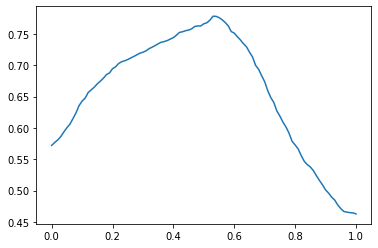

In [39]:
plt.plot(x_list,y_list)

In [52]:
pf = PolynomialFeatures(3)
df_nums_ = pf.fit_transform(df_nums)
feature_list = pf.get_feature_names(df_nums.columns)

In [54]:
poly_df = pd.DataFrame(df_nums_, columns = feature_list)
poly_df

,1,amount_tsh,gps_height,population,days_since_recording,amount_tsh^2,amount_tsh gps_height,amount_tsh population,amount_tsh days_since_recording,gps_height^2,...,gps_height^3,gps_height^2 population,gps_height^2 days_since_recording,gps_height population^2,gps_height population days_since_recording,gps_height days_since_recording^2,population^3,population^2 days_since_recording,population days_since_recording^2,days_since_recording^3
0,1.0,6000.0,1390.0,109.0,3215.0,36000000.0,8340000.0,654000.0,19290000.0,1932100.0,...,2.685619e+09,210598900.0,6.211702e+09,16514590.0,487104650.0,1.436735e+10,1295029.0,38197415.0,1.126649e+09,3.323096e+10
1,1.0,0.0,1399.0,280.0,2492.0,0.0,0.0,0.0,0.0,1957201.0,...,2.738124e+09,548016280.0,4.877345e+09,109681600.0,976166240.0,8.687880e+09,21952000.0,195372800.0,1.738818e+09,1.547548e+10
2,1.0,25.0,686.0,250.0,2501.0,625.0,17150.0,6250.0,62525.0,470596.0,...,3.228289e+08,117649000.0,1.176961e+09,42875000.0,428921500.0,4.290931e+09,15625000.0,156312500.0,1.563750e+09,1.564376e+10
3,1.0,0.0,263.0,58.0,2529.0,0.0,0.0,0.0,0.0,69169.0,...,1.819145e+07,4011802.0,1.749284e+08,884732.0,38577366.0,1.682106e+09,195112.0,8507556.0,3.709588e+08,1.617508e+10
4,1.0,0.0,0.0,0.0,3094.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,2.961835e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,1.0,10.0,1210.0,125.0,2434.0,100.0,12100.0,1250.0,24340.0,1464100.0,...,1.771561e+09,183012500.0,3.563619e+09,18906250.0,368142500.0,7.168471e+09,1953125.0,38031250.0,7.405445e+08,1.441988e+10
59396,1.0,4700.0,1212.0,56.0,3161.0,22090000.0,5696400.0,263200.0,14856700.0,1468944.0,...,1.780360e+09,82260864.0,4.643332e+09,3800832.0,214543392.0,1.211021e+10,175616.0,9912896.0,5.595476e+08,3.158446e+10
59397,1.0,0.0,0.0,0.0,3187.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,3.237026e+10
59398,1.0,0.0,0.0,0.0,3221.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,3.341736e+10


In [59]:
X = pd.concat([poly_df, df_onehot], axis = 1)
y = pd.get_dummies(df_cleaned['status_group']).iloc[:,0]

In [60]:
GBR2 = GradientBoostingRegressor()

GBR.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
preds = GBR.predict(X)


for x in range(100):
    threshold = x/100
    results = list(map(lambda x: 0 if x < threshold else 1, preds))
    a = accuracy_score(results, y)
    print(threshold, a)

0.0 0.5745454545454546
0.01 0.5803367003367004
0.02 0.5842424242424242
0.03 0.5904377104377104
0.04 0.5958585858585859
0.05 0.6026599326599327
0.06 0.6090740740740741
0.07 0.615993265993266
0.08 0.6213468013468013
0.09 0.6351178451178451
0.1 0.6416329966329967
0.11 0.6474579124579125
0.12 0.655
0.13 0.6627609427609428
0.14 0.6677946127946128
0.15 0.6719360269360269
0.16 0.6778114478114479
0.17 0.6827104377104377
0.18 0.6875252525252525
0.19 0.6921885521885522
0.2 0.696969696969697
0.21 0.701043771043771
0.22 0.7037542087542088
0.23 0.7065824915824915
0.24 0.7085016835016835
0.25 0.7105892255892255
0.26 0.7128787878787879
0.27 0.7158249158249158
0.28 0.7188383838383838
0.29 0.7206397306397306
0.3 0.722037037037037
0.31 0.7238552188552189
0.32 0.7267003367003367
0.33 0.7295286195286196
0.34 0.7317171717171718
0.35 0.7354208754208754
0.36 0.7385521885521885
0.37 0.7402693602693603
0.38 0.7421885521885522
0.39 0.7458249158249158
0.4 0.747979797979798
0.41 0.7503872053872054
0.42 0.75259259

0.668973063973064